Ćwiczenia nr 2 - Ćwiczenia nr 2-3 - Techniki wyznaczania VaR (wg. książki J. Hulla)

Weźmy dane dot. dziennych stóp zwrotu dla wybranego waloru (niech te dane będą obejmowały okres od stycznia 2016 roku do końca września 2025 roku). 

Załóżmy, że będzie nas interesowało 500-dniowe okno danych historycznych. Celem pracy jest wyznaczenie ciągu wartości 99% VaR i 99% ES z wykorzystaniem 

metody historycznej, 
metody historycznej z wagami
Uwaga:

Punktem wyjścia jest definicja VaR (a właściwie jej związek z definicją kwantyla empirycznego rozkładu strat). 
To oznacza, że na podstawie danych historycznych (w ramach rozważanego horyzontu czasowego) należy zbudować empiryczny rozkład stóp zwrotu i wyznaczyć jego kwantyl (VaR). Wyznaczenie ES jest równie proste (definicja ES).
Dla metody historycznej można łatwo zdefiniować funkcję implementującą wartości VaR i ES w ramach okna estymacji, a później go przenieść po całym zestawie danych
Dla pozostałych metod trzeba odpowiedzieć sobie na pytanie - jak wyznaczyć empiryczny rozkład takich strat (tj. co tak naprawdę jest stratą (Xi) oraz ile wynosi prawdopodobieństwo poniesienia tej straty (pi) w ramach technik 2/3. Na pewno pomogą definicje z wykładu, ale też (w przypadku użycia pakietu R) polecam zapoznanie się z pakietem distr).


Zadanie dodatkowe:

Jeśli zadanie Ci się spodobało (ew. będziesz chciał mieć bogatszy projekt) możesz rozwiązać jeden (lub więcej) z trzech poniższych problemów.

(problem najłatwiejszy) Dobierz jeszcze 2-3 inne walory - chyba najlepiej powiązane z pierwszym (podobne waluty, podobne spółki giełdowe) - i spróbuj w ramach każdej metody wyznaczyć także owe indeksy ryzyka dla nich. Może uda Ci się zauważyć jakieś podobieństwa w wynikach?
(problem łatwy) Spróbuj wyznaczyć VaR i ES także metodą historyczną uwzględniającą informację o heteroskedastyczności stóp zwrotu, tj. EWMA lub model GARCH(1,1).
(problem łatwy) Na wykładzie mówiliśmy o metodzie Monte Carlo w wyznaczaniu VaR i ES. Załóż, że dane są opisane rozkładem normalnym (jego parametry wyznaczysz na podstawie próby) i spróbuj wykorzystując tę metodę wyznaczyć 99% VaR i 99% ES. Spróbuj odpowiedzieć na pytanie, jak się mają wielkości owego VaR/ES do VaR/ES wyznaczanego z wykorzystaniem np. metody historycznej z wagami. Czy te wnioski wydają się być naturalne?
(problem ciekawy) Dość dużą popularność ma wykorzystanie EVT (extreme value theory) do wyznaczania VAR. Jest to zrozumiałe, bo w dość prosty sposób, do tego umotywowany matematycznie, mogę dobrze definiować ogony rozkładu. Na podstawie fragmentu książki Hulla spróbuj zaimplementować to podejście (zbuduj odpowiednią funkcję). Jeśli Ci się uda, to porównaj te wyniki z innymi metodami. Możesz też dodatkowo sprawdzić działanie tej funkcji i funkcji, którą pewnie znajdziesz w R/Python.

In [82]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [83]:
CSV_PATH = Path('../data/spx_d.csv')

data_frame_daily: pd.DataFrame = pd.read_csv(
        CSV_PATH,
        # usecols=['datetime', 'open', 'high', 'low', 'close'],
        usecols=['Data','Otwarcie','Najwyzszy','Najnizszy','Zamkniecie','Wolumen'],
        parse_dates=['Data']
    )
data_frame_daily.set_index('Data').sort_index().astype('float64')  

# konwersja kolumny 'Data' na datetime, bo bez tego są błedne daty
data_frame_daily['Data'] = pd.to_datetime(data_frame_daily['Data'], errors='coerce')

# usuwam ewentualne błędne wiersze bez dat
data_frame_daily = data_frame_daily.dropna(subset=['Data'])

# indeks i sortuje
data_frame_daily = (
    data_frame_daily
    .set_index('Data')
    .sort_index()
    .astype('float64')
)
print(data_frame_daily.head(10))

            Otwarcie  Najwyzszy  Najnizszy  Zamkniecie       Wolumen
Data                                                                
2015-01-02   2058.90    2072.36    2046.04     2058.20  1.504833e+09
2015-01-05   2054.44    2054.44    2017.34     2020.58  2.110622e+09
2015-01-06   2022.15    2030.25    1992.44     2002.61  2.477839e+09
2015-01-07   2005.55    2029.61    2005.55     2025.90  2.114156e+09
2015-01-08   2030.61    2064.08    2030.61     2062.14  2.185561e+09
2015-01-09   2063.45    2064.43    2038.33     2044.81  1.868967e+09
2015-01-12   2046.13    2049.30    2022.58     2028.26  1.920256e+09
2015-01-13   2031.58    2056.93    2008.25     2023.03  2.281833e+09
2015-01-14   2018.40    2018.40    1988.44     2011.27  2.432600e+09
2015-01-15   2013.75    2021.35    1991.47     1992.67  2.375956e+09


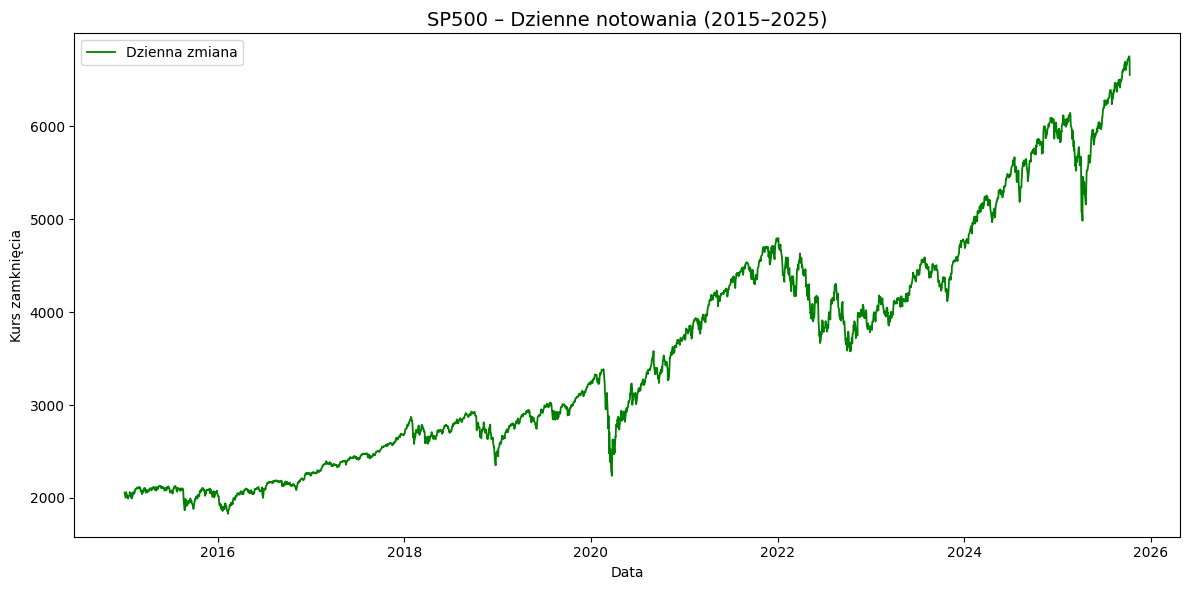

In [84]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    data_frame_daily.index,
    data_frame_daily['Zamkniecie'],
    label='Dzienna zmiana',
    color='green',
    linewidth=1.3
)

ax.set_title('SP500 – Dzienne notowania (2015–2025)', fontsize=14)
ax.set_xlabel('Data')
ax.set_ylabel('Kurs zamknięcia')
ax.legend()
plt.tight_layout()
plt.show()

Teraz wyznaczam logarytmiczne stopy zwrotu i tworzę funckje pomocnicze, żeby sprawdzić czy dane wyglądają sensownie.
Wykorzystuję do tego funkcje pomocnicze z poprzednich ćwiczeń z tą różnicą, iż zamiast zwracać zwroty w procentach, będę je zwracac
w ułamkach.

In [85]:
# Funkcja pomocznica do liczenia zwrotów
def compute_returns(series: pd.Series) -> pd.DataFrame:
    """
    Obliczam stopy zwrotu zgodnie ze wzorami:
    Z_simple_frac(t) = 100 * (X_t - X_{t-1}) / X_{t-1}
    Z_log_frac(t) = 100 * ln(X_t / X_{t-1})
    """
    returns = pd.DataFrame(index=series.index)
    returns["simple_frac"] = (series - series.shift(1)) / series.shift(1)
    returns["log_frac"] = np.log(series / series.shift(1))
    return returns

# Funkcja pomocnicza do rysowania wykresów zwrotów
def plot_returns(df: pd.DataFrame, title: str):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df.index, df["simple_frac"], label="Stopa prosta")
    ax.plot(df.index, df["log_frac"], label="Stopa logarytmiczna")
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Data")
    ax.set_ylabel("Stopa zwrotu (%)")
    ax.legend()

    plt.tight_layout()
    plt.show()

            simple_frac  log_frac
Data                             
2025-09-29     0.002636  0.002632
2025-09-30     0.004091  0.004083
2025-10-01     0.003400  0.003394
2025-10-02     0.000618  0.000618
2025-10-03     0.000066  0.000066
2025-10-06     0.003647  0.003640
2025-10-07    -0.003811 -0.003819
2025-10-08     0.005828  0.005811
2025-10-09    -0.002756 -0.002759
2025-10-10    -0.027112 -0.027486


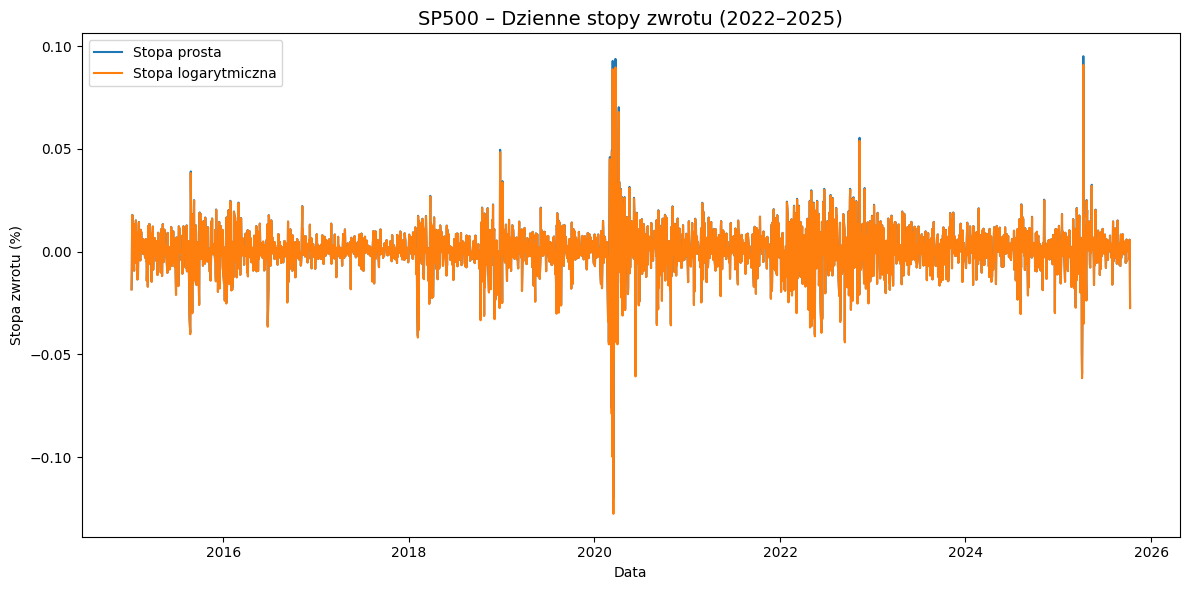

In [86]:
# DZIENNE
returns_daily = compute_returns(data_frame_daily["Zamkniecie"])
print(returns_daily.tail(10))
plot_returns(returns_daily, "SP500 – Dzienne stopy zwrotu (2022–2025)")

Teraz biorę się za właściwe liczenie VaR historycznego. Tak jak wcześńiej pisałem, wykorzytsam stopę logarytmiczną.

In [87]:
losses_daily = -returns_daily["log_frac"]
losses_daily = losses_daily.dropna()

In [88]:
WINDOW = 500 # ile dni bierzemy pod uwagę
QUANTILE_LEVEL = 0.99  # czyli 99% VaR
QUANTILE_LEVEL_PERCENTAHE = QUANTILE_LEVEL * 100

In [89]:
var_series = []

losses = losses_daily.values # przekształcenie, żeby łatwiej pracować na danych

for i in range(WINDOW, len(losses)):
    window_losses = losses[i-WINDOW:i]
    var_value = np.quantile(window_losses, QUANTILE_LEVEL)
    var_series.append(var_value)

# Konwersja spowrotem do serii pandas by mieć daty
var_index = losses_daily.index[WINDOW:]
var_series = pd.Series(var_series, index=var_index)
# print(var_series)

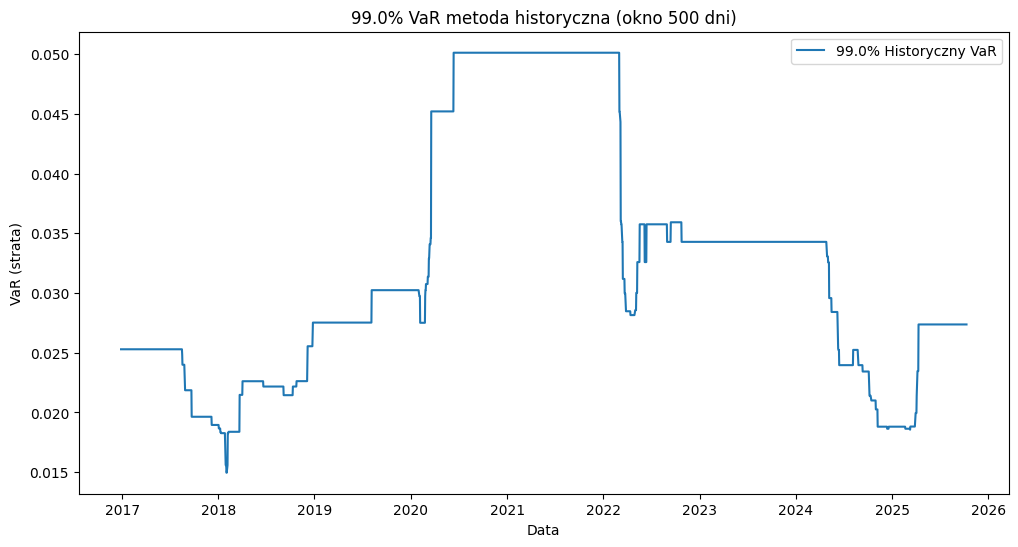

In [92]:
plt.figure(figsize=(12,6))
plt.plot(var_series, label=f"{QUANTILE_LEVEL_PERCENTAHE}% Historyczny VaR")
plt.title(f"{QUANTILE_LEVEL_PERCENTAHE}% VaR metoda historyczna (okno {WINDOW} dni)")
plt.xlabel("Data")
plt.ylabel("VaR (strata)")
plt.legend()
plt.show()


# ES - Expected Shortfall

In [93]:
es_series = []
var_series = []

for i in range(WINDOW, len(losses)):
    window_losses = losses[i-WINDOW:i]
    
    # VaR tak samo jak wcześniej
    var_value = np.quantile(window_losses, QUANTILE_LEVEL)
    var_series.append(var_value)

    # ES: średnia strata większa niż VaR
    es_value = window_losses[window_losses > var_value].mean()
    es_series.append(es_value)

var_series = pd.Series(var_series, index=losses_daily.index[WINDOW:])
es_series  = pd.Series(es_series, index=losses_daily.index[WINDOW:])


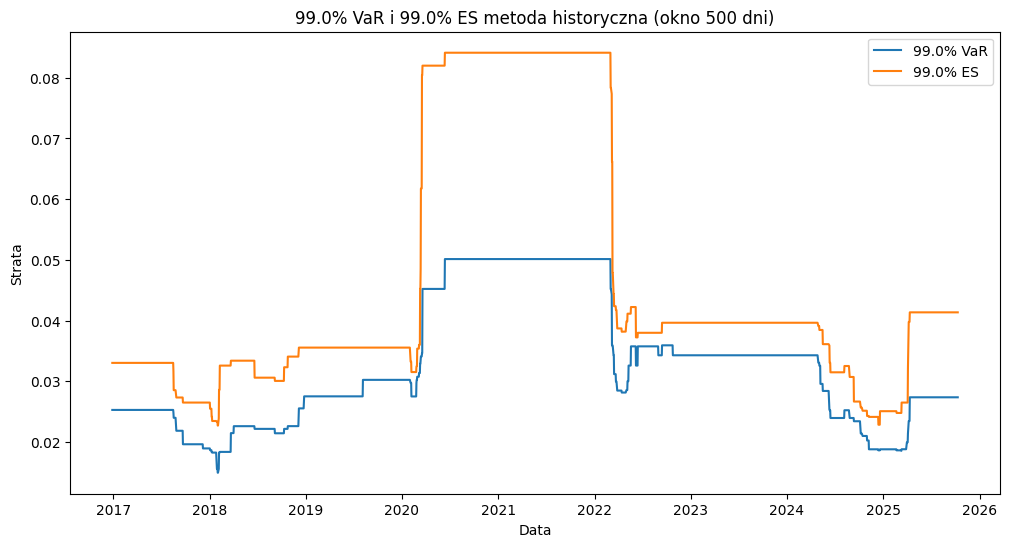

In [94]:
plt.figure(figsize=(12,6))
plt.plot(var_series, label=f"{QUANTILE_LEVEL_PERCENTAHE}% VaR")
plt.plot(es_series, label=f"{QUANTILE_LEVEL_PERCENTAHE}% ES")
plt.title(f"{QUANTILE_LEVEL_PERCENTAHE}% VaR i {QUANTILE_LEVEL_PERCENTAHE}% ES metoda historyczna (okno {WINDOW} dni)")
plt.xlabel("Data")
plt.ylabel("Strata")
plt.legend()
plt.show()
